In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# %reload_ext autoreload

In [10]:
from pathlib import Path
import matplotlib.pyplot as plt
import skimage.io as io
import numpy as np
import homography, rectification, my_types, utils

In [11]:
DATA = Path("data")

# Pick Correspondences

In [12]:
PICK_NEW = False
im1_name = DATA / "doll1.jpg"
im2_name = DATA / "doll2.jpg"
im3_name = DATA / "doll3.jpg"

if PICK_NEW:
    %matplotlib tk
    im1_pts = utils.pick_points(im1_name, 8)
    im2_pts = utils.pick_points(im2_name, 8)
    # im3_pts = utils.pick_points(im3_name, 8)
    utils.save_points(im1_pts, im1_name)
    utils.save_points(im2_pts, im2_name)
    # utils.save_points(im3_pts, im3_name)
else:
    %matplotlib inline
    im1_pts = utils.load_points(im1_name)
    im2_pts = utils.load_points(im2_name)
    # im3_pts = utils.load_points(im3_name)

In [13]:
im1_pts = im1_pts[:4]
im2_pts = im2_pts[:4]

In [14]:
im1 = my_types.to_img_arr(im1_name)
im2 = my_types.to_img_arr(im2_name)
im3 = my_types.to_img_arr(im3_name)

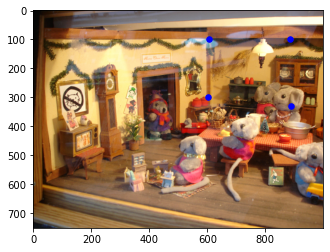

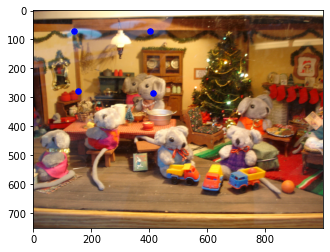

In [15]:
utils.plot_pts(im1, im1_pts)
utils.plot_pts(im2, im2_pts)

# Image Rectification

In [22]:
plane_pts = np.array([[360,  70], [360, 306], [560 , 306], [560,  70]])

In [ ]:
h_matrix1 = homography.homo_matrix(im1_pts, plane_pts)
warp1, shift_pts1 = homography.forward_warp(im1, h_matrix1)

=====src=====
(750, 1000, 3)
0 0
749 999
====target====
(1167, 999, 3)
0 0
1166 999
=====interpolate=====


In [ ]:
warp_pts1 = homography.warp_pts(im1_pts, h_matrix1, shift_pts1)
warp_pts1

In [ ]:
h_matrix2 = homography.homo_matrix(im2_pts, plane_pts)
warp2, shift_pts2 = homography.forward_warp(im2, h_matrix2)

In [ ]:
warp_pts2 = homography.warp_pts(im2_pts, h_matrix2, shift_pts2)
warp_pts2

In [ ]:
utils.plot_pts(warp1, warp_pts1)
utils.plot_pts(warp2, warp_pts2)

In [ ]:
aligned1, aligned2 = rectification.align(warp1, warp2, warp_pts1, warp_pts2)
plt.figure()
plt.imshow(aligned1)
plt.figure()
plt.imshow(aligned2)